In [2]:
import os
import torch
import copy
from tqdm import tqdm_notebook
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
from tqdm import tqdm_notebook
import cv2
import numpy as np
import glob
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from torchvision import transforms
import re
import torch.nn.functional as F

c:\users\aryan\appdata\local\programs\python\python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Extracting frames from videos

In [3]:
def get_frames(filename, n_frames= 1):
    frames = []
    v_cap = cv2.VideoCapture(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT)) #cv2.CAP_PROP_FRAME_COUNT counts the tot. no. of frames in a video
    frame_list= np.linspace(0, v_len, n_frames+1, dtype=np.int16) #np.linspace returns evenly spaced numbers over a specified interval- numpy.linspace(start, stop, num=no. of nos. to generate, endpoint=True, retstep=False, dtype=None, axis=0)
                                                                                                                                                #both start and stop included
    for fn in range(v_len):
        success, frame = v_cap.read() #Reading ( cam. read() ) from a VideoCapture returns a tuple (return value, image) . With the first item you check whether the reading was successful, and if it was then you proceed to use the returned image .
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
            frames.append(frame)
    v_cap.release() #When you call cap. release() , then: release software resource. release hardware resource
    return frames, v_len

def store_frames(frames, path2store):
    for ii, frame in enumerate(frames): #Enumerate() method adds a counter to an iterable and returns it in a form of enumerating object
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
        path2img = os.path.join(path2store, "frame"+str(ii)+".jpg")
        cv2.imwrite(path2img, frame)

def get_vids(path2ajpgs):
    listOfCats = os.listdir(path2ajpgs)   # listofCats - scoring, non scoring 
    ids = []
    labels = []
    for catg in listOfCats:
      
        path2catg = os.path.join(path2ajpgs, catg)      
        listOfSubCats = os.listdir(path2catg)           
        path2subCats= [os.path.join(path2catg,los) for los in listOfSubCats] 
        ids.extend(path2subCats)
        labels.extend([catg]*len(listOfSubCats))
    
    return ids, labels, listOfCats 

In [4]:
video_paths = glob.glob('YouTubeClips/YouTubeClips'+"/*.avi")
len(video_paths)

1970

In [5]:
vid_dir = 'YouTubeClips/YouTubeClips'
frame_dir = 'frames'
  
'''for i,vid_path in enumerate(video_paths):  
  
    frames, l = get_frames(vid_path, 49)
    vid_name = vid_path.replace(vid_dir,'')
    path2store = frame_dir + vid_name.replace(".avi", "")
    os.makedirs(path2store, exist_ok = True) 
    store_frames(frames, path2store)
    print(f"video {i}/1970 done", end = '\r')'''

'for i,vid_path in enumerate(video_paths):  \n  \n    frames, l = get_frames(vid_path, 49)\n    vid_name = vid_path.replace(vid_dir,\'\')\n    path2store = frame_dir + vid_name.replace(".avi", "")\n    os.makedirs(path2store, exist_ok = True) \n    store_frames(frames, path2store)\n    print(f"video {i}/1970 done", end = \'\r\')'

# Preprocessing Captions

In [6]:
import spacy
spacy_eng = spacy.load("en_core_web_sm")
class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token

    def __init__(self, name):
        self.name = name
        self.word2index = {'PAD': 0, 'SOS': 1, 'EOS': 2}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.num_words = 3
        self.num_sentences = 0 
        self.longest_sentence = 0
    


    def add_word(self, word):
        
        if word not in self.word2count:
            # First entry of word into vocabulary
            self.word2count[word] = 1
            self.word2index[word] = self.num_words
            self.index2word[self.num_words] = word
            self.num_words += 1

        else:
            self.word2count[word] += 1
        
  
    def tokenizer(self,text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def add_sentence(self, sentence):
        sentence_len = 0
        #for word in sentence.split(' '):
        for word in self.tokenizer(sentence):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

In [7]:
import pandas as pd
df = pd.read_csv("video_corpus.csv")
df.head()

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
0,mv89psg6zh4,33,46,588702,unverified,55,Slovene,Papagaj se umiva pod tekočo vodo v lijaku.
1,mv89psg6zh4,33,46,588702,unverified,37,Slovene,Papagaj se umiva pod tekočo vodo v lijaku.
2,mv89psg6zh4,33,46,362812,unverified,11,Macedonian,папагал се бања
3,mv89psg6zh4,33,46,968828,unverified,84,German,Ein Wellensittich duscht unter einem Wasserhahn.
4,mv89psg6zh4,33,46,203142,unverified,14,Romanian,o pasare sta intr-o chiuveta.


In [8]:
df_eng = df[df['Language'] == 'English']
len(df_eng)

85511

In [9]:
df_eng.head()

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
18,mv89psg6zh4,33,46,682611,clean,66,English,A bird in a sink keeps getting under the runni...
19,mv89psg6zh4,33,46,760882,clean,16,English,A bird is bathing in a sink.
20,mv89psg6zh4,33,46,878566,clean,76,English,A bird is splashing around under a running fau...
21,mv89psg6zh4,33,46,707318,clean,14,English,A bird is bathing in a sink.
22,mv89psg6zh4,33,46,135621,clean,58,English,A bird is standing in a sink drinking water th...


In [10]:
# creating the vocabulary 
vocab = Vocabulary('test')

# adding words to the vocabulary 
for sentence in df_eng['Description']:
    vocab.add_sentence(str(sentence))

d = {}
idx = 0
for id in df_eng['VideoID'].unique():
  while idx <(len(df_eng)):
    if df_eng['VideoID'].iloc[idx] == id:
      


      sentence = df_eng['Description'].iloc[idx]
      sent_idxs = [1]
      i = 0
      
      for word in vocab.tokenizer(sentence):
 
          sent_idxs.append(vocab.to_index(word))
          i+=1

      sent_idxs.append(2)

      while i < ((vocab.longest_sentence) + 1):
          sent_idxs.append(0)
          i+=1
      
      
      d[id] = sent_idxs
       
      break
    idx+=1

In [11]:
len(d)

1586

In [12]:
len(df_eng['VideoID'].unique())

1586

# Creating the Dataset

In [13]:
frame_paths = glob.glob('frames'+"/*")
len(frame_paths)

1970

In [14]:
class VideoDataset(Dataset):
  
  def __init__(self, root_dir, caption_dict, transform):
    self.root_dir = root_dir
    self.transform = transform
    
    self.frame_paths = glob.glob(root_dir+'/*')
    #print(self.frame_paths[0])
    self.video_ids = []
    for frame_path in self.frame_paths:
        video_id = frame_path.replace(root_dir+'\\', "").replace(".avi", "")
        video_id = re.sub("_[0-9]+", "", video_id)
        self.video_ids.append(video_id)

   
    self.dic = caption_dict
    #print(self.video_ids[0], self.dic.keys())
   
    idx = 0
    while idx <(len(self.video_ids)):
      if self.video_ids[idx] not in self.dic:
        self.video_ids.remove(self.video_ids[idx])
        self.frame_paths.remove(self.frame_paths[idx])
      else:
        idx+=1

    
  def __len__(self):
    return len(self.frame_paths)

  def __getitem__(self, idx):


    frame_path = self.frame_paths[idx]
    video_id = frame_path.replace(root_dir+'\\', "").replace(".avi", "")
    video_id = re.sub("_[0-9]+", "", video_id)
    
    caption = self.dic[video_id]
   

    frames_p = glob.glob(frame_path+'/*.jpg')
    frames = []
    for idx,f in enumerate(frames_p):
        frame = Image.open(f)
        frame = self.transform(frame)
        frames.append(frame)
    while idx<48:
        frames.append(torch.zeros(3,224,224))
        idx+=1
    frames = torch.stack(frames)
    return frames, torch.tensor(caption)

In [15]:
from torchvision import transforms
root_dir = 'frames'
transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224)),  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
dataset = VideoDataset(root_dir, d,transforms)
print(len(dataset))

1905


In [16]:
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SOS a boy is checking a calendar . EOS PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 

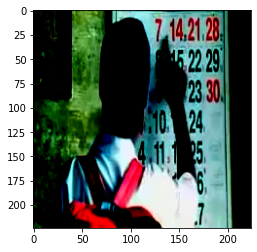

In [17]:
for vids, cap in train_dataloader:
  for c in cap[0]:
    print(vocab.to_word(int(c)), end = " ")
  plt.imshow(vids[0][0].permute(1,2,0))
  break

In [18]:
import numpy as np 
vocabs = vocab.word2index.keys()

def load_embeds(root_dir):
    embeddings_index = dict()
    f = open(root_dir, encoding = 'utf8')

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    f.close()
    return embeddings_index
embeddings_index = load_embeds('glove.6B.300d.txt')

In [19]:
import torch
def load_embed_weights(embeddings_index, embed_dim, vocab, vocab_size):
    matrix_len = vocab_size
    weights_matrix = np.zeros((matrix_len, embed_dim))
    words_found = 0

    for i, word in enumerate(vocab):
        try: 
            weights_matrix[i] = embeddings_index[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(embed_dim, ))
    weights_matrix = torch.tensor(weights_matrix)
    return weights_matrix
weights_matrix = load_embed_weights(embeddings_index, 300, vocabs, vocab.num_words)
weights_matrix.shape

torch.Size([13254, 300])

In [20]:
def output_to_caption(outputs, index):
    preds = outputs[index]
    preds = torch.argmax(preds, dim = 1)
    preds = preds.cpu()
    preds = np.array(preds)
    for index in preds:
        if index == 2:
            break    
        if index != 1:    
            print(vocab.to_word(index), end = ' ')

def tensor_to_caption(preds, index):
    preds = preds[index].cpu()
    preds = np.array(preds)
    for index in preds:
        if index == 2:
            break
        if index != 1:    
            print(vocab.to_word(index), end = ' ')

def tensor_to_image(img_list, index):
    img = img_list[index].permute(1,2,0)
    plt.figure()
    plt.imshow(img.cpu())

In [21]:
import torchvision
import torch.nn as  nn

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model = torch.nn.Sequential(*(list(self.model.children())[:-2]))
    def forward(self, x):
        features =  self.model(x)
        return features.reshape(-1, 2048, 49) # [49,2048,49]
encoder = Encoder()

In [22]:
class attention(nn.Module):
  def __init__(self, feature_dim, hidden_dim, embed_dim, num_vecs):
    super().__init__()
    
    self.features_fc = nn.Linear(feature_dim, num_vecs)
    self.hidden_fc = nn.Linear(hidden_dim, num_vecs)
    self.context_fc = nn.Linear(num_vecs, 1)
    self.input_fc = nn.Linear(embed_dim, hidden_dim)
    self.hidden_gate_fc = nn.Linear(hidden_dim, hidden_dim)
    self.s_fc = nn.Linear(hidden_dim, num_vecs)
    self.ones = torch.ones(num_vecs,1).to(device)
    self.tanh = torch.tanh
    self.sigma = torch.sigmoid
  
  def forward(self, features, hidden, inputs, memory):

    c1 = []
    #c1 = c1.to(device)
    for i in range(features.shape[0]):
      f = self.features_fc(features[i,:,:])            #3,3
      h = self.hidden_fc(hidden[i,:].unsqueeze(0))     #1,3
      h1 = self.ones @ h
      c = self.tanh(f+h1)                               #3,3
      z = self.context_fc(c).permute((1,0))            #1,3
      a = F.softmax(z, dim = 1)
      test = a @ features[i,:,:]

    
      gate = self.sigma( self.input_fc(inputs[i,:]) + self.hidden_gate_fc(hidden[i,:]) )
      s = gate * self.tanh(memory[i,:])                
  
      ws = self.s_fc(s.unsqueeze(0))                   #1,3
      
      w = self.tanh(ws+h)                              #1,3
      i = self.context_fc(w)                           
      
      concat = F.softmax(torch.cat((z,i), dim = 1), dim = 1).squeeze(0)
      b = concat[-1]
  
      c1b = b*s + (1-b)*(test)
      c1.append(c1b)


    c1 = torch.stack(c1)

    return  c1.squeeze(1)

In [23]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, weights_matrix, device, num_layers=1):
        super(Decoder, self).__init__()
        
        # define the properties
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        



        self.init_fc = nn.Linear(in_features = 49, out_features = 1)
        # lstm cell
        #self.lstm_cell = nn.LSTMCell(input_size = embed_size + hidden_size, hidden_size=hidden_size)
        self.lstm_cell = nn.LSTMCell(input_size = embed_size, hidden_size=hidden_size)
        # output fully connected layer
        self.fc_out = nn.Linear(in_features = self.hidden_size*2, out_features = self.vocab_size)
    
        # embedding layer
        self.embed = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embed_size)
        self.embed.weight.requires_grad = False
        self.embed.load_state_dict({'weight': weights_matrix})
        
        self.attn = attention(2048, 2048, 300, 49).to(device)
        
        #self.embed_test = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embed_size)
        #self.embed_test.weight.requires_grad = False
        #self.embed_test.load_state_dict({'weight': weights_matrix})
         
    def forward(self, features, captions, test = False):


        # features = [49,2048,49], captions = [1,num_words]
        
        # batch size
        batch_size = 1   
        
        # init the hidden and cell states to zeros
        
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(device)    #[1,2048]
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(device)      #[1,2048]
        
        #hidden_state = torch.mean(features, dim = 1)    #[32,512]
        #cell_state = torch.mean(features, dim = 1)      #[32,512]
        
        states = (hidden_state, cell_state)
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).to(device) #captions.size(1) is the number of words 
        # outputs = [1,num_words,vocab_size]
        
        # embed the captions
        captions_embed = self.embed(captions)    #[1,num_words,300]
        features1 = self.init_fc(features).squeeze(-1).unsqueeze(0)       #[1,49,2048]
        
        # pass the caption word by word
        if test == False: 
            for t in range(captions.size(1)):

                # getting the features of the image to be focussed on  
                #context = attn(features, hidden_state)  #[32,512]

                # concatnating it with the input word
                #inputs = torch.cat((context, captions_embed[:, t, :]), dim = 1) # [32,812] 

                #passing the combination through lstm
                #hidden_state, cell_state = self.lstm_cell(inputs, (hidden_state, cell_state))
                hidden_state, cell_state = self.lstm_cell(captions_embed[:,t,:], (hidden_state, cell_state))


                context = self.attn(features1, hidden_state, captions_embed[:,t,:], cell_state)

                out = torch.cat((context, hidden_state), dim = 1)
                # output of the attention mechanism
                out = self.fc_out(out)

                # build the output tensor
                outputs[:, t, :] = out      

            return F.log_softmax(outputs, dim = 2)
        
        

        
    
        else:
            
            word_idxs = torch.ones(batch_size).long().to(device)
            
            
            for i in range(captions.size(1)):
                
                word_embeds = self.embed(word_idxs)     #[32,300]
            
                
                hidden_state, cell_state = self.lstm_cell(word_embeds, (hidden_state, cell_state))


                context = self.attn(features, hidden_state, word_embeds, cell_state)

                out = torch.cat((context, hidden_state), dim = 1)
                # output of the attention mechanism
                out = self.fc_out(out)
            
                # build the output tensor
                outputs[:, i, :] = out
                
                word_idxs = torch.argmax(out, dim = 1)
                

            return F.log_softmax(outputs, dim = 2)

              
            
        
        
        
vocab_size = vocab.num_words
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#attn = attention(2048, 2048, 300, 49)
#attn = attn.to(device)
decoder = Decoder(300,2048, vocab_size,weights_matrix, device)

In [35]:
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    device = torch.device("cuda")
    decoder.load_state_dict(torch.load('final_run3.pth'))
    for idx, (img_list, caption) in enumerate (train_dataloader):

        img_list = img_list[0].to(device)
        caption_target = caption[:,1:]    # skips SOS
        caption_train = caption[:,:-1]    # skips EOS
        caption_target, caption_train = caption_target.to(device).long(), caption_train.to(device).long()
        features = encoder(img_list) # [49,2048,49]
        outputs = decoder(features, caption_train)
        print('\npredicted caption:')
        output_to_caption(outputs, 0)
        print("\n\nactual caption:")
        tensor_to_caption(caption, 0)
        
        break


predicted caption:
a woman is laying a motorcycle with a wheels in circles . 

actual caption:
a monkey is riding a bicycle with training wheels in circles . 

In [33]:
import pyprind
def train(encoder, decoder, trainloader, criterion, optimizer_decoder, epoch, device):
    
    train_loss = []
    bar = pyprind.ProgBar(len(trainloader), bar_char='█')
    for idx, (img_list, caption) in enumerate (trainloader):

        img_list = img_list[0].to(device)
        caption_target = caption[:,1:]    # skips SOS
        caption_train = caption[:,:-1]    # skips EOS
        caption_target, caption_train = caption_target.to(device).long(), caption_train.to(device).long()
        features = encoder(img_list) # [49,2048,49]
        outputs = decoder(features, caption_train)
        #print(outputs.shape)
        
        #optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        
        loss = criterion(outputs.view(-1, vocab_size), caption_target.contiguous().view(-1))
        
        train_loss.append(loss.item())
        
        loss.backward()
        #optimizer_encoder.step()
        optimizer_decoder.step()
        bar.update()
        
        
        print('train loss : {}'.format(np.mean(train_loss)), end = '\r')
    print('\npredicted caption:')
    output_to_caption(outputs, 0)
    print("\n\nactual caption:")
    tensor_to_caption(caption, 0)
    print()
    return np.mean(train_loss)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
criterion = nn.NLLLoss(ignore_index = 0 )
criterion.to(device)
#encoder = model
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr = 1e-2)
#optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr = 1e-2)
encoder.to(device)
decoder.to(device)
epochs = 8
#decoder.load_state_dict(torch.load('../input/final-run2/final_run2.pth'))
best_loss = 1.947587166120374
for epoch in range(epochs):
    loss = train(encoder, decoder, train_dataloader, criterion, optimizer_decoder, epoch, device)
    if loss < best_loss:
        best_loss = loss
        torch.save(decoder.state_dict(), 'final_run1.pth')
print("OVERALL TRAINING COMPLETE")

cuda


0% [█                             ] 100% | ETA: 01:04:09

0% [██                            ] 100% | ETA: 01:03:09

0% [███                           ] 100% | ETA: 01:00:24

0% [████                          ] 100% | ETA: 00:57:35

0% [█████                         ] 100% | ETA: 00:55:06

0% [██████                        ] 100% | ETA: 00:52:48

0% [███████                       ] 100% | ETA: 00:50:24

0% [████████                      ] 100% | ETA: 00:48:13

0% [█████████                     ] 100% | ETA: 00:45:58

0% [██████████                    ] 100% | ETA: 00:43:43

0% [███████████                   ] 100% | ETA: 00:41:34

0% [████████████                  ] 100% | ETA: 00:39:25

0% [█████████████                 ] 100% | ETA: 00:37:13

0% [██████████████                ] 100% | ETA: 00:35:04

0% [███████████████               ] 100% | ETA: 00:32:48

0% [████████████████              ] 100% | ETA: 00:30:35

0% [█████████████████             ] 100% | ETA: 00:28:25

0% [██████████████████            ] 100% | ETA: 00:26:14

0% [███████████████████           ] 100% | ETA: 00:24:03

0% [████████████████████          ] 100% | ETA: 00:21:52

0% [█████████████████████         ] 100% | ETA: 00:19:40

0% [██████████████████████        ] 100% | ETA: 00:17:28

0% [███████████████████████       ] 100% | ETA: 00:15:18

0% [████████████████████████      ] 100% | ETA: 00:13:07

0% [█████████████████████████     ] 100% | ETA: 00:10:55

0% [██████████████████████████    ] 100% | ETA: 00:08:45

0% [███████████████████████████   ] 100% | ETA: 00:06:32

0% [████████████████████████████  ] 100% | ETA: 00:04:20

0% [█████████████████████████████ ] 100% | ETA: 00:02:10

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:05:42


train loss : 2.2234390550828356
predicted caption:
a dices a reddish liquid into a saucepan of sausage from a large glass jug . 

actual caption:
someone pours a reddish liquid into a saucepan of sausage from a large glass jug . 


0% [█                             ] 100% | ETA: 01:03:20

0% [██                            ] 100% | ETA: 01:00:41

0% [███                           ] 100% | ETA: 00:58:38

0% [████                          ] 100% | ETA: 00:56:25

0% [█████                         ] 100% | ETA: 00:54:15

0% [██████                        ] 100% | ETA: 00:52:08

0% [███████                       ] 100% | ETA: 00:49:57

0% [████████                      ] 100% | ETA: 00:47:58

0% [█████████                     ] 100% | ETA: 00:45:47

0% [██████████                    ] 100% | ETA: 00:43:36

0% [███████████                   ] 100% | ETA: 00:41:27

0% [████████████                  ] 100% | ETA: 00:39:19

0% [█████████████                 ] 100% | ETA: 00:37:05

0% [██████████████                ] 100% | ETA: 00:34:56

0% [███████████████               ] 100% | ETA: 00:32:43

0% [████████████████              ] 100% | ETA: 00:30:31

0% [█████████████████             ] 100% | ETA: 00:28:21

0% [██████████████████            ] 100% | ETA: 00:26:12

0% [███████████████████           ] 100% | ETA: 00:24:00

0% [████████████████████          ] 100% | ETA: 00:21:50

0% [█████████████████████         ] 100% | ETA: 00:19:38

0% [██████████████████████        ] 100% | ETA: 00:17:25

0% [███████████████████████       ] 100% | ETA: 00:15:15

0% [████████████████████████      ] 100% | ETA: 00:13:06

0% [█████████████████████████     ] 100% | ETA: 00:10:54

0% [██████████████████████████    ] 100% | ETA: 00:08:44

0% [███████████████████████████   ] 100% | ETA: 00:06:31

0% [████████████████████████████  ] 100% | ETA: 00:04:20

0% [█████████████████████████████ ] 100% | ETA: 00:02:10

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:05:34


train loss : 1.9814763389625574
predicted caption:
a man is to his puppy . 

actual caption:
a man talks about his puppy . 


0% [█                             ] 100% | ETA: 01:02:45

0% [██                            ] 100% | ETA: 01:00:39

0% [███                           ] 100% | ETA: 00:58:43

0% [████                          ] 100% | ETA: 00:56:51

0% [█████                         ] 100% | ETA: 00:54:40

0% [██████                        ] 100% | ETA: 00:52:28

0% [███████                       ] 100% | ETA: 00:50:14

0% [████████                      ] 100% | ETA: 00:48:09

0% [█████████                     ] 100% | ETA: 00:45:57

0% [██████████                    ] 100% | ETA: 00:43:42

0% [███████████                   ] 100% | ETA: 00:41:29

0% [████████████                  ] 100% | ETA: 00:39:19

0% [█████████████                 ] 100% | ETA: 00:37:10

0% [██████████████                ] 100% | ETA: 00:35:01

0% [███████████████               ] 100% | ETA: 00:32:47

0% [████████████████              ] 100% | ETA: 00:30:34

0% [█████████████████             ] 100% | ETA: 00:28:24

0% [██████████████████            ] 100% | ETA: 00:26:16

0% [███████████████████           ] 100% | ETA: 00:24:04

0% [████████████████████          ] 100% | ETA: 00:21:53

0% [█████████████████████         ] 100% | ETA: 00:19:40

0% [██████████████████████        ] 100% | ETA: 00:17:28

0% [███████████████████████       ] 100% | ETA: 00:15:18

0% [████████████████████████      ] 100% | ETA: 00:13:07

0% [█████████████████████████     ] 100% | ETA: 00:10:55

0% [██████████████████████████    ] 100% | ETA: 00:08:44

0% [███████████████████████████   ] 100% | ETA: 00:06:32

0% [████████████████████████████  ] 100% | ETA: 00:04:20

0% [█████████████████████████████ ] 100% | ETA: 00:02:10

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:05:36


train loss : 1.8531298061837675
predicted caption:
a kitten is playing a tree . 

actual caption:
a man is felling a tree . 


0% [█                             ] 100% | ETA: 01:02:52

0% [██                            ] 100% | ETA: 01:01:10

0% [███                           ] 100% | ETA: 00:59:09

0% [████                          ] 100% | ETA: 00:56:51

0% [█████                         ] 100% | ETA: 00:54:42

0% [██████                        ] 100% | ETA: 00:52:34

0% [███████                       ] 100% | ETA: 00:50:14

0% [████████                      ] 100% | ETA: 00:48:03

0% [█████████                     ] 100% | ETA: 00:45:46

0% [██████████                    ] 100% | ETA: 00:43:36

0% [███████████                   ] 100% | ETA: 00:41:27

0% [████████████                  ] 100% | ETA: 00:39:16

0% [█████████████                 ] 100% | ETA: 00:37:03

0% [██████████████                ] 100% | ETA: 00:34:54

0% [███████████████               ] 100% | ETA: 00:32:42

0% [████████████████              ] 100% | ETA: 00:30:29

0% [█████████████████             ] 100% | ETA: 00:28:18

0% [██████████████████            ] 100% | ETA: 00:26:08

0% [███████████████████           ] 100% | ETA: 00:23:57

0% [████████████████████          ] 100% | ETA: 00:21:49

0% [█████████████████████         ] 100% | ETA: 00:19:36

0% [██████████████████████        ] 100% | ETA: 00:17:24

0% [███████████████████████       ] 100% | ETA: 00:15:15

0% [████████████████████████      ] 100% | ETA: 00:13:05

0% [█████████████████████████     ] 100% | ETA: 00:10:53

0% [██████████████████████████    ] 100% | ETA: 00:08:44

0% [███████████████████████████   ] 100% | ETA: 00:06:32

0% [████████████████████████████  ] 100% | ETA: 00:04:20

0% [█████████████████████████████ ] 100% | ETA: 00:02:10

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:05:31


train loss : 1.864269495909921
predicted caption:
a elephants are splashing . 

actual caption:
two animals are fighting . 


0% [█                             ] 100% | ETA: 01:03:15

0% [██                            ] 100% | ETA: 01:01:02

0% [███                           ] 100% | ETA: 00:58:34

0% [████                          ] 100% | ETA: 00:56:22

0% [█████                         ] 100% | ETA: 00:54:33

0% [██████                        ] 100% | ETA: 00:52:24

0% [███████                       ] 100% | ETA: 00:50:13

0% [████████                      ] 100% | ETA: 00:48:01

0% [█████████                     ] 100% | ETA: 00:45:48

0% [██████████                    ] 100% | ETA: 00:43:38

0% [███████████                   ] 100% | ETA: 00:41:28

0% [████████████                  ] 100% | ETA: 00:39:19

0% [█████████████                 ] 100% | ETA: 00:37:04

0% [██████████████                ] 100% | ETA: 00:34:53

0% [███████████████               ] 100% | ETA: 00:32:41

0% [████████████████              ] 100% | ETA: 00:30:31

0% [█████████████████             ] 100% | ETA: 00:28:21

0% [██████████████████            ] 100% | ETA: 00:26:12

0% [███████████████████           ] 100% | ETA: 00:24:01

0% [████████████████████          ] 100% | ETA: 00:21:52

0% [█████████████████████         ] 100% | ETA: 00:19:40

0% [██████████████████████        ] 100% | ETA: 00:17:27

0% [███████████████████████       ] 100% | ETA: 00:15:17

0% [████████████████████████      ] 100% | ETA: 00:13:07

0% [█████████████████████████     ] 100% | ETA: 00:10:54

0% [██████████████████████████    ] 100% | ETA: 00:08:44

0% [███████████████████████████   ] 100% | ETA: 00:06:32

0% [████████████████████████████  ] 100% | ETA: 00:04:20

0% [█████████████████████████████ ] 100% | ETA: 00:02:10

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:05:34


train loss : 1.8411819701276113
predicted caption:
a puppy is takes sunglasses out of a dark bag . puts them on . 

actual caption:
a woman sunbather takes sunglasses out of a dark bag and puts them on . 


0% [█                             ] 100% | ETA: 01:02:40

0% [██                            ] 100% | ETA: 01:00:51

0% [███                           ] 100% | ETA: 00:59:01

0% [████                          ] 100% | ETA: 00:56:37

0% [█████                         ] 100% | ETA: 00:54:22

0% [██████                        ] 100% | ETA: 00:52:22

0% [███████                       ] 100% | ETA: 00:50:08

0% [████████                      ] 100% | ETA: 00:47:57

0% [█████████                     ] 100% | ETA: 00:45:44

0% [██████████                    ] 100% | ETA: 00:43:33

0% [███████████                   ] 100% | ETA: 00:41:24

0% [████████████                  ] 100% | ETA: 00:39:18

0% [█████████████                 ] 100% | ETA: 00:37:09

0% [██████████████                ] 100% | ETA: 00:35:01

0% [███████████████               ] 100% | ETA: 00:32:46

0% [████████████████              ] 100% | ETA: 00:30:32

0% [█████████████████             ] 100% | ETA: 00:28:23

0% [██████████████████            ] 100% | ETA: 00:26:12

0% [███████████████████           ] 100% | ETA: 00:23:59

0% [████████████████████          ] 100% | ETA: 00:21:49

0% [█████████████████████         ] 100% | ETA: 00:19:38

0% [██████████████████████        ] 100% | ETA: 00:17:25

0% [███████████████████████       ] 100% | ETA: 00:15:15

0% [████████████████████████      ] 100% | ETA: 00:13:05

0% [█████████████████████████     ] 100% | ETA: 00:10:53

0% [██████████████████████████    ] 100% | ETA: 00:08:44

0% [███████████████████████████   ] 100% | ETA: 00:06:32

0% [████████████████████████████  ] 100% | ETA: 00:04:20

0% [█████████████████████████████ ] 100% | ETA: 00:02:10

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:05:34


train loss : 1.7337929362778275
predicted caption:
a men women are synchronized dancing . 

actual caption:
three animated women are synchronized dancing . 


0% [█                             ] 100% | ETA: 01:03:24

0% [██                            ] 100% | ETA: 01:00:43

0% [███                           ] 100% | ETA: 00:58:38

0% [████                          ] 100% | ETA: 00:56:25

0% [█████                         ] 100% | ETA: 00:54:22

0% [██████                        ] 100% | ETA: 00:52:23

0% [███████                       ] 100% | ETA: 00:50:18

0% [████████                      ] 100% | ETA: 00:48:07

0% [█████████                     ] 100% | ETA: 00:45:54

0% [██████████                    ] 100% | ETA: 00:43:47

0% [███████████                   ] 100% | ETA: 00:41:33

0% [████████████                  ] 100% | ETA: 00:39:21

0% [█████████████                 ] 100% | ETA: 00:37:10

0% [██████████████                ] 100% | ETA: 00:34:59

0% [███████████████               ] 100% | ETA: 00:32:47

0% [████████████████              ] 100% | ETA: 00:30:35

0% [█████████████████             ] 100% | ETA: 00:28:24

0% [██████████████████            ] 100% | ETA: 00:26:13

0% [███████████████████           ] 100% | ETA: 00:24:02

0% [████████████████████          ] 100% | ETA: 00:21:50

0% [█████████████████████         ] 100% | ETA: 00:19:38

0% [██████████████████████        ] 100% | ETA: 00:17:26

0% [███████████████████████       ] 100% | ETA: 00:15:16

0% [████████████████████████      ] 100% | ETA: 00:13:06

0% [█████████████████████████     ] 100% | ETA: 00:10:54

0% [██████████████████████████    ] 100% | ETA: 00:08:44

0% [███████████████████████████   ] 100% | ETA: 00:06:32

0% [████████████████████████████  ] 100% | ETA: 00:04:20

0% [█████████████████████████████ ] 100% | ETA: 00:02:10

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:05:32


train loss : 1.7265346263884873
predicted caption:
a woman is and fires a rifle . 

actual caption:
a man aims and fires a rifle . 


0% [█                             ] 100% | ETA: 01:03:36

0% [██                            ] 100% | ETA: 01:00:59

0% [███                           ] 100% | ETA: 00:58:32

0% [████                          ] 100% | ETA: 00:56:14

0% [█████                         ] 100% | ETA: 00:54:14

0% [██████                        ] 100% | ETA: 00:52:00

0% [███████                       ] 100% | ETA: 00:49:51

0% [████████                      ] 100% | ETA: 00:47:47

0% [█████████                     ] 100% | ETA: 00:45:38

0% [██████████                    ] 100% | ETA: 00:43:26

0% [███████████                   ] 100% | ETA: 00:41:22

0% [████████████                  ] 100% | ETA: 00:39:12

0% [█████████████                 ] 100% | ETA: 00:37:03

0% [██████████████                ] 100% | ETA: 00:34:53

0% [███████████████               ] 100% | ETA: 00:32:40

0% [████████████████              ] 100% | ETA: 00:30:29

0% [█████████████████             ] 100% | ETA: 00:28:20

0% [██████████████████            ] 100% | ETA: 00:26:12

0% [███████████████████           ] 100% | ETA: 00:23:59

0% [████████████████████          ] 100% | ETA: 00:21:51

0% [█████████████████████         ] 100% | ETA: 00:19:38

0% [██████████████████████        ] 100% | ETA: 00:17:27

0% [███████████████████████       ] 100% | ETA: 00:15:17

0% [████████████████████████      ] 100% | ETA: 00:13:07

0% [█████████████████████████     ] 100% | ETA: 00:10:55

0% [██████████████████████████    ] 100% | ETA: 00:08:44

0% [███████████████████████████   ] 100% | ETA: 00:06:32

0% [████████████████████████████  ] 100% | ETA: 00:04:20

0% [█████████████████████████████ ] 100% | ETA: 00:02:10

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:05:34


train loss : 1.7721244326179109
predicted caption:
a man cutting potatoes bread . 

actual caption:
a person slices a bread . 
OVERALL TRAINING COMPLETE
